<a href="https://colab.research.google.com/github/RizkyBagusParamadani30/Boids-and-SFM/blob/main/Copy_of_Tugas_implementasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Implementasi Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## LOAD DATA

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import randint, uniform, loguniform
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

try:
    set_config(transform_output="pandas")
except Exception:
    pass


DATA_PATH = '/content/drive/Othercomputers/My MacBook Pro/4. Kuliah S3/1. SMT 1/1. Topilk Machine Learning /Tugas_UTS/penjualan_kambing_2024.csv'
assert os.path.exists(DATA_PATH), f"File tidak ditemukan: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

df.head(5)

,tanggal,jenis,tahap_umur,umur_bln,bobot_kg,kelamin,harga_rp
0,10/01/2023,Gibas,Muda,10,26.2,Betina,850000
1,19/01/2023,Gibas,Muda,9,24.8,Jantan,1100000
2,28/01/2023,Peranakan Etawa (PE),Muda,12,34.6,Jantan,2750000
3,29/01/2023,Peranakan Etawa (PE),Dewasa,17,42.9,Betina,3350000
4,01/02/2023,Jawa Randu,Dewasa,18,36.8,Jantan,2400000


## EDA dan Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tanggal     100 non-null    object 
 1   jenis       100 non-null    object 
 2   tahap_umur  100 non-null    object 
 3   umur_bln    100 non-null    int64  
 4   bobot_kg    100 non-null    float64
 5   kelamin     100 non-null    object 
 6   harga_rp    100 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 5.6+ KB


In [ ]:
if "tanggal" not in df.columns:
    raise ValueError("Kolom 'tanggal' tidak ditemukan di DataFrame.")


df["tanggal"] = (
    df["tanggal"].astype(str).str.strip()
      .str.replace(r"\s+", " ", regex=True)
      .str.replace(".", "-", regex=False)
      .str.replace("/", "-", regex=False)
      .str.replace(",", " ", regex=False)
      .str.replace("–", "-", regex=False)
      .str.replace("_", "-", regex=False)
)

bulan_map = {
    "Januari": "January", "Februari": "February", "Maret": "March", "April": "April",
    "Mei": "May", "Juni": "June", "Juli": "July", "Agustus": "August", "September": "September",
    "Oktober": "October", "Nopember": "November", "November": "November", "Desember": "December",
    "Jan": "Jan", "Feb": "Feb", "Mar": "Mar", "Apr": "Apr", "Mei": "May", "Jun": "Jun",
    "Jul": "Jul", "Agu": "Aug", "Sep": "Sep", "Okt": "Oct", "Nov": "Nov", "Des": "Dec"
}
for indo, eng in bulan_map.items():
    df["tanggal"] = df["tanggal"].str.replace(rf"\b{indo}\b", eng, regex=True)

def parse_multi(series):
    possible_formats = [
        "%d-%m-%Y", "%Y-%m-%d", "%d-%m-%y",
        "%d %B %Y", "%d %b %Y", "%B %d %Y", "%b %d %Y"
    ]
    result = pd.to_datetime(series, errors="coerce", dayfirst=True)
    for fmt in possible_formats:
        mask = result.isna()
        if mask.any():
            parsed = pd.to_datetime(series[mask], format=fmt, errors="coerce")
            result.loc[mask] = parsed
    return result

df["tanggal"] = parse_multi(df["tanggal"])


TARGET_COL = "harga_rp"
if TARGET_COL not in df.columns:
    raise ValueError(f"Kolom target '{TARGET_COL}' tidak ada di dataset.")
if not pd.api.types.is_numeric_dtype(df[TARGET_COL]):
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")


if "kelamin" in df.columns and "jenis_kelamin" not in df.columns:
    df = df.rename(columns={"kelamin": "jenis_kelamin"})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tanggal        100 non-null    datetime64[ns]
 1   jenis          100 non-null    object        
 2   tahap_umur     100 non-null    object        
 3   umur_bln       100 non-null    int64         
 4   bobot_kg       100 non-null    float64       
 5   jenis_kelamin  100 non-null    object        
 6   harga_rp       100 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.6+ KB


In [ ]:
df.drop(columns=['tanggal']).describe()


,umur_bln,bobot_kg,harga_rp
count,100.000000,100.000000,1.000000e+02
mean,13.220000,31.038000,1.968500e+06
std,5.256223,8.141957,9.627049e+05
min,6.000000,18.000000,6.000000e+05
25%,9.000000,25.950000,1.300000e+06
50%,12.000000,30.000000,1.750000e+06
75%,18.000000,36.075000,2.300000e+06
max,24.000000,51.500000,4.750000e+06


In [ ]:
df.isnull().sum()

,0
tanggal,0
jenis,0
tahap_umur,0
umur_bln,0
bobot_kg,0
jenis_kelamin,0
harga_rp,0


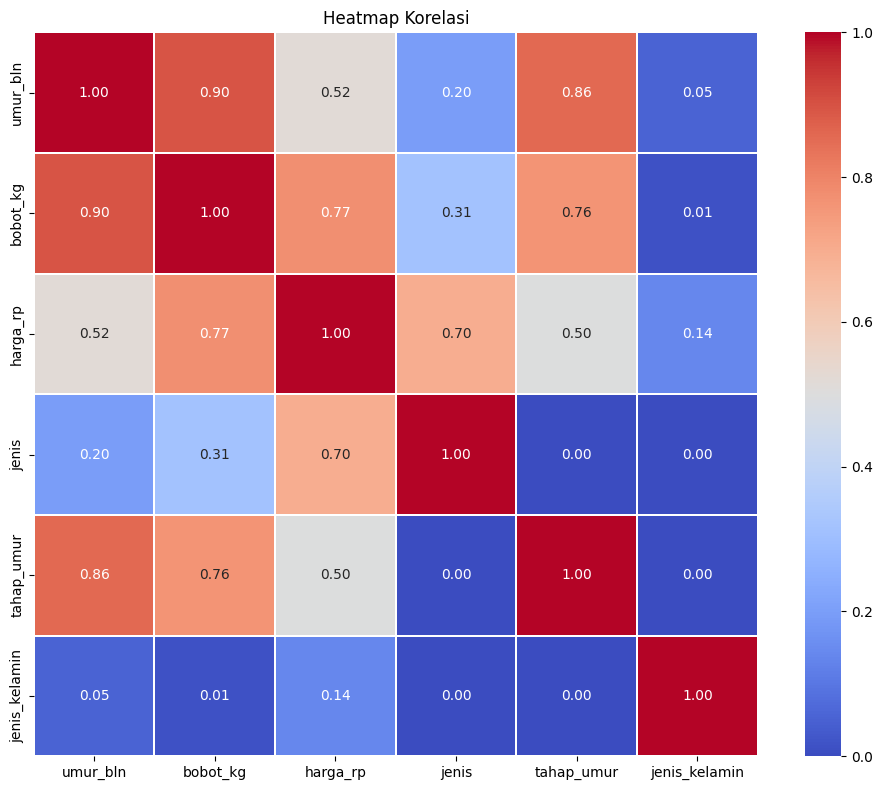


=== Korelasi tiap fitur terhadap harga_rp ===
bobot_kg         0.774
jenis            0.697
umur_bln         0.516
tahap_umur       0.496
jenis_kelamin    0.138
Name: harga_rp, dtype: float64


In [ ]:
def correlation_ratio(categories, values):
    """Correlation ratio (η) untuk kategori vs numerik"""
    cat_groups = pd.unique(categories)
    n_total = len(values)
    mean_total = np.nanmean(values)
    ss_between = sum([
        len(values[categories == cat]) * (np.nanmean(values[categories == cat]) - mean_total) ** 2
        for cat in cat_groups
    ])
    ss_total = np.nansum((values - mean_total) ** 2)
    eta = np.sqrt(ss_between / ss_total) if ss_total > 0 else 0
    return eta


def cramers_v(x, y):
    """Cramér's V untuk kategori vs kategori"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


df_temp = df.copy()
if "tanggal" in df_temp.columns:
    df_temp = df_temp.drop(columns=["tanggal"]) # Hapus kolom tanggal jika masih ada

categorical_cols = df_temp.select_dtypes(exclude=[np.number]).columns.tolist()
numerical_cols   = df_temp.select_dtypes(include=[np.number]).columns.tolist()

all_cols = numerical_cols + categorical_cols
corr_matrix = pd.DataFrame(np.zeros((len(all_cols), len(all_cols))), columns=all_cols, index=all_cols)

for i, col1 in enumerate(all_cols):
    for j, col2 in enumerate(all_cols):
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        # Numerik vs Numerik (Pearson)
        elif col1 in numerical_cols and col2 in numerical_cols:
            # Pastikan tidak ada NaN yang tersisa jika belum ditangani
            corr_matrix.loc[col1, col2] = df_temp[[col1, col2]].corr(method="pearson").iloc[0,1]
        # Kategorikal vs Numerik (Correlation Ratio)
        elif col1 in categorical_cols and col2 in numerical_cols:
            corr_matrix.loc[col1, col2] = correlation_ratio(df_temp[col1], df_temp[col2])
        # Numerik vs Kategorikal (Correlation Ratio, order dibalik)
        elif col1 in numerical_cols and col2 in categorical_cols:
            corr_matrix.loc[col1, col2] = correlation_ratio(df_temp[col2], df_temp[col1])
        # Kategorikal vs Kategorikal (Cramér's V)
        elif col1 in categorical_cols and col2 in categorical_cols:
            corr_matrix.loc[col1, col2] = cramers_v(df_temp[col1], df_temp[col2])


plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix.astype(float),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.05,
    cbar=True,
    vmin=0, vmax=1
)
plt.title("Heatmap Korelasi")
plt.tight_layout()
plt.show()

# hubungan fitur sama harga
print("\n=== Korelasi tiap fitur terhadap harga_rp ===")
if "harga_rp" in corr_matrix.columns:
    target_corr = corr_matrix["harga_rp"].drop("harga_rp").sort_values(ascending=False)
    print(target_corr.round(3))
else:
    print("Kolom 'harga_rp' tidak ditemukan dalam matriks korelasi.")

Kolom: umur_bln
IQR = 9.00, Batas bawah = -4.50, Batas atas = 31.50
Jumlah outlier: 0 dari total 100 baris
Kolom: bobot_kg
IQR = 10.13, Batas bawah = 10.76, Batas atas = 51.26
Jumlah outlier: 1 dari total 100 baris
Kolom: harga_rp
IQR = 1000000.00, Batas bawah = -200000.00, Batas atas = 3800000.00
Jumlah outlier: 7 dari total 100 baris


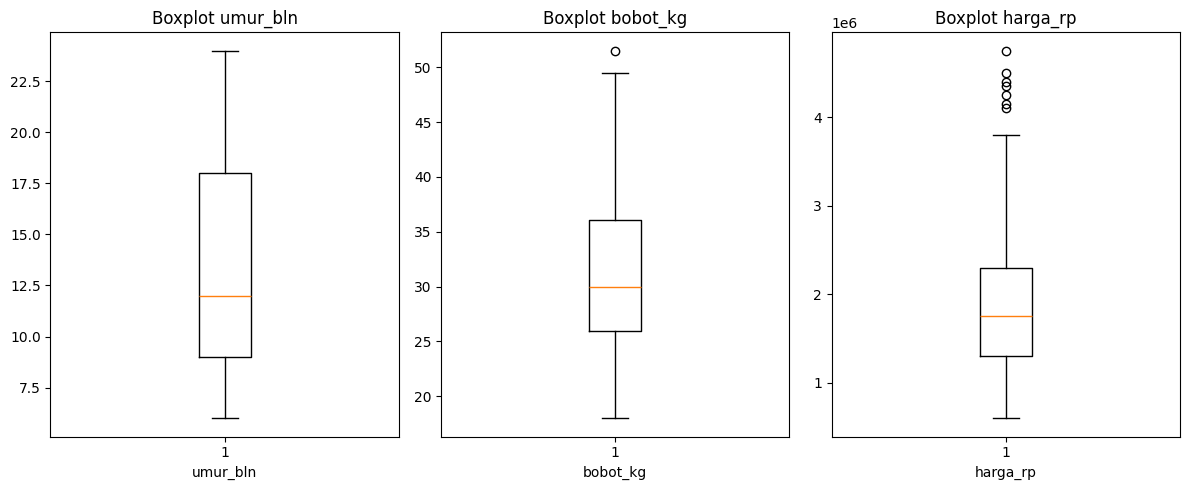

In [ ]:
num_cols = ['umur_bln', 'bobot_kg', 'harga_rp']

def detect_outliers_iqr(df_in, col):
    Q1 = df_in[col].quantile(0.25)
    Q3 = df_in[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask_outlier = (df_in[col] < lower) | (df_in[col] > upper)
    print(f"Kolom: {col}")
    print(f"IQR = {IQR:.2f}, Batas bawah = {lower:.2f}, Batas atas = {upper:.2f}")
    print(f"Jumlah outlier: {mask_outlier.sum()} dari total {len(df_in)} baris")
    return df_in[mask_outlier]

outliers_dict = {}
for col in num_cols:
    outliers_dict[col] = detect_outliers_iqr(df, col)

plt.figure(figsize=(12,5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.boxplot(df[col])
    plt.title(f"Boxplot {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [ ]:
# def remove_outliers_iqr(df_in, columns, factor=1.5):
#     df_clean = df_in.copy()
#     total_removed = 0
#     for col in columns:
#         Q1 = df_clean[col].quantile(0.25)
#         Q3 = df_clean[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower = Q1 - factor * IQR
#         upper = Q3 + factor * IQR
#         before = len(df_clean)
#         df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
#         removed = before - len(df_clean)
#         total_removed += removed
#     return df_clean

# df = remove_outliers_iqr(df, num_cols, factor=1.5)

In [ ]:
drop_cols = [TARGET_COL]
X = df.drop(columns=drop_cols)
y = df[TARGET_COL].astype(float)

print("Fitur X atau Variabel Independen:")
print(X.head())
print("\nTarget y atau Variabel Dependen:")
print(y.head())

Fitur X atau Variabel Independen:
     tanggal                 jenis tahap_umur  umur_bln  bobot_kg  \
0 2023-01-10                 Gibas       Muda        10      26.2   
1 2023-01-19                 Gibas       Muda         9      24.8   
2 2023-01-28  Peranakan Etawa (PE)       Muda        12      34.6   
3 2023-01-29  Peranakan Etawa (PE)     Dewasa        17      42.9   
4 2023-02-01            Jawa Randu     Dewasa        18      36.8   

  jenis_kelamin  
0        Betina  
1        Jantan  
2        Jantan  
3        Betina  
4        Jantan  

Target y atau Variabel Dependen:
0     850000.0
1    1100000.0
2    2750000.0
3    3350000.0
4    2400000.0
Name: harga_rp, dtype: float64


In [ ]:
def date_featurizer_func(df_):
    df2 = df_.copy()
    if "tanggal" in df2.columns:

        if not pd.api.types.is_datetime64_any_dtype(df2["tanggal"]):
            df2["tanggal"] = _safe_parse_tanggal(df2["tanggal"])
        if pd.api.types.is_datetime64_any_dtype(df2["tanggal"]):
            df2["year"]  = df2["tanggal"].dt.year
            df2["month"] = df2["tanggal"].dt.month
            df2["week"]  = df2["tanggal"].dt.isocalendar().week.astype(int)
            df2["dow"]   = df2["tanggal"].dt.dayofweek
        df2 = df2.drop(columns=["tanggal"])
    return df2

def date_feat_names(transformer, input_features=None):
    cols = list(input_features) if input_features is not None else []
    if "tanggal" in cols:
        cols = [c for c in cols if c != "tanggal"]
        cols = cols + ["year", "month", "week", "dow"]
    return np.array(cols, dtype=object)

date_featurizer = FunctionTransformer(
    date_featurizer_func,
    feature_names_out=date_feat_names,
    validate=False
)

def make_ohe():
    try:
        return OneHotEncoder(
            handle_unknown="infrequent_if_exist",
            min_frequency=0.01,
            sparse_output=False
        )
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_exclude=np.number)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",RobustScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_selector),
        ("cat", categorical_pipe, categorical_selector)
    ],
    remainder="drop"
)

# misahin X dan y (fitur sama target)
X = df.drop(columns=["harga_rp"])
y = df["harga_rp"]

preview_pipe = Pipeline(steps=[
    ("date_feat", date_featurizer),
    ("prep", preprocess),
])
X_prep = preview_pipe.fit_transform(X)

try:
    feature_names = preview_pipe.get_feature_names_out()
except Exception:
    feature_names = [f"feature_{i}" for i in range(X_prep.shape[1])]

X_prep_df = pd.DataFrame(X_prep, columns=feature_names)
display(X_prep_df.head(5))

,num__umur_bln,num__bobot_kg,num__year,num__month,num__week,num__dow,cat__jenis_Gibas,cat__jenis_Jawa Randu,cat__jenis_Peranakan Etawa (PE),cat__tahap_umur_Dewasa,cat__tahap_umur_Muda,cat__jenis_kelamin_Betina,cat__jenis_kelamin_Jantan
0,-0.222222,-0.375309,-1.0,-5.0,-3.142857,-0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.333333,-0.513580,-1.0,-5.0,-3.000000,0.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.000000,0.454321,-1.0,-5.0,-2.857143,0.50,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.555556,1.274074,-1.0,-5.0,-2.857143,0.75,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.666667,0.671605,-1.0,-4.0,-2.714286,-0.25,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## MODEL

In [ ]:
rf_selector_est = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
auto_selector = SelectFromModel(
    estimator=rf_selector_est,
    threshold="median",
    prefit=False
)

rf_main = RandomForestRegressor(
    n_estimators=600,
    max_depth=10,
    min_samples_leaf=3,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf_main,
    func=np.log1p,
    inverse_func=np.expm1
)


pipe = Pipeline(steps=[
    ("date_feat", date_featurizer),
    ("prep", preprocess),
    ("select", auto_selector),
    ("model", model)
])


try:
    pipe.set_output(transform="pandas")
except Exception:
    pass


if "tanggal" in df.columns and df["tanggal"].notna().any():
    cv = TimeSeriesSplit(n_splits=5)
else:
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False)
scoring_metrics = {
    "mape": make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "rmse": rmse_scorer,
    "r2": "r2",
}

def print_cv(name, scores):
    print(f"\n[{name}] Per-fold:")
    for i, (mape_i, mae_i, rmse_i, r2_i) in enumerate(
        zip(scores["test_mape"], scores["test_mae"], scores["test_rmse"], scores["test_r2"]), start=1
    ):
        print(f"Fold {i}: MAPE={-mape_i*100:.2f}% | MAE={-mae_i:,.0f} | RMSE={-rmse_i:,.0f} | R²={r2_i:.3f}")

    mean_mape = -scores["test_mape"].mean()*100
    mean_mae  = -scores["test_mae"].mean()
    mean_rmse = -scores["test_rmse"].mean()
    mean_r2   =  scores["test_r2"].mean()

    print(f"[{name}] Rata-rata: MAPE={mean_mape:.2f}% | MAE={mean_mae:,.0f} | RMSE={mean_rmse:.0f} | R²={mean_r2:.3f}")
    return dict(MAPE=mean_mape, MAE=mean_mae, RMSE=mean_rmse, R2=mean_r2)

# Baseline CV
base_scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring_metrics)
base_mean = print_cv("Sebelum Tuning", base_scores)


param_grid = {
    "model__regressor__n_estimators": randint(300, 1200),
    "model__regressor__max_depth": randint(4, 20),
    "model__regressor__min_samples_leaf": randint(1, 10),
    "model__regressor__max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv,
    scoring=scoring_metrics,
    refit="mape",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\n[Tuning] Menjalankan RandomizedSearchCV ...")
search.fit(X, y)
print("Best params:", search.best_params_)
print(f"Best CV mean MAPE (refit): {-search.best_score_*100:.2f}%")

tuned_pipe = search.best_estimator_
tuned_scores = cross_validate(tuned_pipe, X, y, cv=cv, scoring=scoring_metrics)
tuned_mean = print_cv("Setelah Tuning", tuned_scores)

def delta_str(before, after, bigger_is_better=False):
    diff = after - before
    arrow = "↑" if (bigger_is_better and diff > 0) or ((not bigger_is_better) and diff < 0) else "↓"
    sign = "+" if diff >= 0 else ""
    return f"{arrow} {sign}{diff:.2f}"

print("\n=== Perbandingan Rata-rata (Sesudah vs Sebelum) ===")
print(f"MAPE: {tuned_mean['MAPE']:.2f}% vs {base_mean['MAPE']:.2f}%  ({delta_str(base_mean['MAPE'], tuned_mean['MAPE'])} pp, lebih kecil lebih baik)")
print(f"MAE : {tuned_mean['MAE']:,.0f}  vs {base_mean['MAE']:,.0f}   ({delta_str(base_mean['MAE'], tuned_mean['MAE'])}, lebih kecil lebih baik)")
print(f"RMSE: {tuned_mean['RMSE']:,.0f} vs {base_mean['RMSE']:,.0f}  ({delta_str(base_mean['RMSE'], tuned_mean['RMSE'])}, lebih kecil lebih baik)")
print(f"R²  : {tuned_mean['R2']:.3f}  vs {base_mean['R2']:.3f}   ({delta_str(base_mean['R2'], tuned_mean['R2'], bigger_is_better=True)}, lebih besar lebih baik)")



[Sebelum Tuning] Per-fold:
Fold 1: MAPE=29.36% | MAE=724,023 | RMSE=979,096 | R²=0.204
Fold 2: MAPE=24.66% | MAE=302,540 | RMSE=433,371 | R²=0.790
Fold 3: MAPE=16.08% | MAE=353,610 | RMSE=549,704 | R²=0.776
Fold 4: MAPE=14.41% | MAE=277,637 | RMSE=325,419 | R²=0.870
Fold 5: MAPE=13.59% | MAE=209,817 | RMSE=232,269 | R²=0.909
[Sebelum Tuning] Rata-rata: MAPE=19.62% | MAE=373,526 | RMSE=503972 | R²=0.710

[Tuning] Menjalankan RandomizedSearchCV ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'model__regressor__max_depth': 5, 'model__regressor__max_features': None, 'model__regressor__min_samples_leaf': 2, 'model__regressor__n_estimators': 1084}
Best CV mean MAPE (refit): 17.32%

[Setelah Tuning] Per-fold:
Fold 1: MAPE=34.70% | MAE=802,542 | RMSE=982,445 | R²=0.199
Fold 2: MAPE=19.95% | MAE=234,250 | RMSE=279,301 | R²=0.913
Fold 3: MAPE=7.94% | MAE=187,474 | RMSE=276,388 | R²=0.943
Fold 4: MAPE=11.54% | MAE=245,179 | RMSE=305,445 | R²=0.886
Fold 5: MAPE=12

In [ ]:
gbr_main = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    max_features=None,
    random_state=42
)
gbr_model = TransformedTargetRegressor(
    regressor=gbr_main,
    func=np.log1p,
    inverse_func=np.expm1
)
gbr_pipe = Pipeline(steps=[
    ("date_feat", date_featurizer),
    ("prep", preprocess),
    ("select", auto_selector),
    ("model", gbr_model)
])

try:
    gbr_pipe.set_output(transform="pandas")
except Exception:
    pass

if "tanggal" in df.columns and df["tanggal"].notna().any():
    cv = TimeSeriesSplit(n_splits=5)
else:
    cv = KFold(n_splits=5, shuffle=True, random_state=42)


gbr_base_scores = cross_validate(gbr_pipe, X, y, cv=cv, scoring=scoring_metrics)
gbr_base_mean   = print_cv("GBR Sebelum Tuning", gbr_base_scores)


gbr_param_grid = {
    # jumlah pohon boosting
    "model__regressor__n_estimators": randint(300, 1500),
    # learning rate
    "model__regressor__learning_rate": loguniform(1e-3, 3e-1),
    # kedalaman pohon base learner
    "model__regressor__max_depth": randint(2, 8),
    # stochastic gradient boosting
    "model__regressor__subsample": uniform(0.6, 0.4),
    # jumlah fitur acak per pohon
    "model__regressor__max_features": [None, "sqrt", "log2"],
    # regularisasi tambahan
    "model__regressor__min_samples_leaf": randint(1, 10),
}

gbr_search = RandomizedSearchCV(
    estimator=gbr_pipe,
    param_distributions=gbr_param_grid,
    n_iter=100,
    cv=cv,
    scoring=scoring_metrics,
    refit="mape",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\n[Tuning-GBR] Menjalankan RandomizedSearchCV ...")
gbr_search.fit(X, y)
print("Best params (GBR):", gbr_search.best_params_)
print(f"Best CV mean MAPE GBR (refit): {-gbr_search.best_score_*100:.2f}%")

gbr_tuned_pipe   = gbr_search.best_estimator_
gbr_tuned_scores = cross_validate(gbr_tuned_pipe, X, y, cv=cv, scoring=scoring_metrics)
gbr_tuned_mean   = print_cv("GBR Setelah Tuning", gbr_tuned_scores)


import pandas as pd

summary_rows = [
    {"Model": "RF (Baseline)",  **{k: v for k, v in base_mean.items()}},
    {"Model": "RF (Tuned)",     **{k: v for k, v in tuned_mean.items()}},
    {"Model": "GBR (Baseline)", **{k: v for k, v in gbr_base_mean.items()}},
    {"Model": "GBR (Tuned)",    **{k: v for k, v in gbr_tuned_mean.items()}},
]
summary_df = pd.DataFrame(summary_rows)[["Model", "MAPE", "MAE", "RMSE", "R2"]]


print(summary_df.sort_values("MAPE", ascending=True).to_string(index=False))


def best_flag(series, larger_is_better=False):
    if larger_is_better:
        best = series.max()
        return series.apply(lambda x: "★" if x == best else "")
    else:
        best = series.min()
        return series.apply(lambda x: "★" if x == best else "")

summary_df["BEST_MAPE"] = best_flag(summary_df["MAPE"], larger_is_better=False)
summary_df["BEST_MAE"]  = best_flag(summary_df["MAE"],  larger_is_better=False)
summary_df["BEST_RMSE"] = best_flag(summary_df["RMSE"], larger_is_better=False)
summary_df["BEST_R2"]   = best_flag(summary_df["R2"],   larger_is_better=True)

print(summary_df[["Model", "MAPE", "BEST_MAPE", "MAE", "BEST_MAE", "RMSE", "BEST_RMSE", "R2", "BEST_R2"]]
      .sort_values("MAPE", ascending=True).to_string(index=False))


[GBR Sebelum Tuning] Per-fold:
Fold 1: MAPE=40.19% | MAE=802,891 | RMSE=921,312 | R²=0.295
Fold 2: MAPE=17.34% | MAE=209,225 | RMSE=254,010 | R²=0.928
Fold 3: MAPE=7.97% | MAE=150,623 | RMSE=195,938 | R²=0.972
Fold 4: MAPE=13.97% | MAE=231,643 | RMSE=304,566 | R²=0.886
Fold 5: MAPE=12.37% | MAE=214,761 | RMSE=268,778 | R²=0.878
[GBR Sebelum Tuning] Rata-rata: MAPE=18.37% | MAE=321,828 | RMSE=388921 | R²=0.792

[Tuning-GBR] Menjalankan RandomizedSearchCV ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params (GBR): {'model__regressor__learning_rate': np.float64(0.009613502684660007), 'model__regressor__max_depth': 7, 'model__regressor__max_features': 'log2', 'model__regressor__min_samples_leaf': 7, 'model__regressor__n_estimators': 1466, 'model__regressor__subsample': np.float64(0.7502331810559776)}
Best CV mean MAPE GBR (refit): 12.96%

[GBR Setelah Tuning] Per-fold:
Fold 1: MAPE=19.61% | MAE=478,713 | RMSE=632,892 | R²=0.667
Fold 2: MAPE=16.75% | MAE=218,803 |

### Model RF

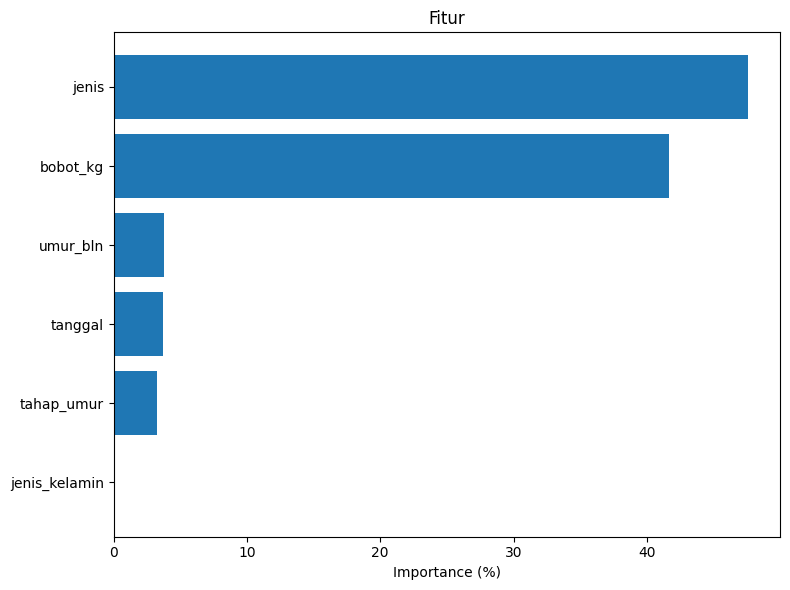

In [ ]:
perm = permutation_importance(
    tuned_pipe, X, y,
    n_repeats=8,
    random_state=42,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False)
)

raw_features = list(X.columns)
imp_df = pd.DataFrame({
    "feature": raw_features,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

imp_df["importance_pct"] = (
    imp_df["importance_mean"] / imp_df["importance_mean"].sum() * 100
)


topk = min(15, len(imp_df))
plt.figure(figsize=(8, 6))
plt.barh(
    imp_df["feature"].head(topk)[::-1],
    imp_df["importance_pct"].head(topk)[::-1]
)
plt.xlabel("Importance (%)")
plt.title("Fitur")
plt.tight_layout()
plt.show()

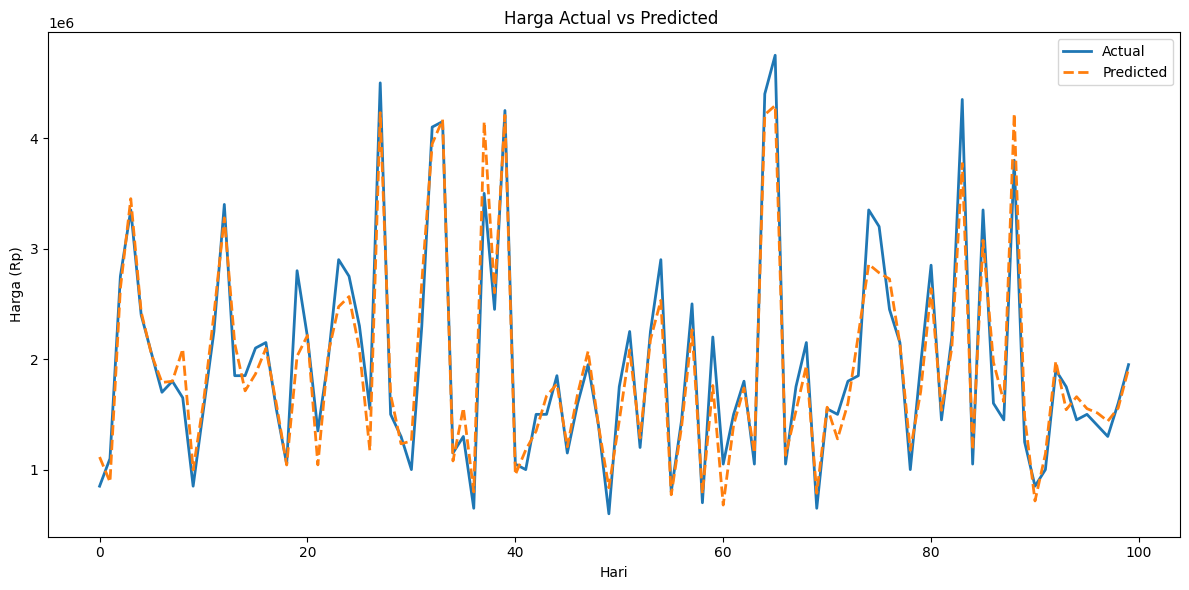

In [ ]:
cv_oof = KFold(n_splits=5, shuffle=True, random_state=42)
x_axis_full = np.arange(len(X))

X_cv = X.reset_index(drop=True)
y_cv = y.reset_index(drop=True)
y_oof = np.full(shape=len(X_cv), fill_value=np.nan, dtype=float)

for tr_idx, te_idx in cv_oof.split(X_cv, y_cv):
    tuned_pipe.fit(X_cv.iloc[tr_idx], y_cv.iloc[tr_idx])
    y_oof[te_idx] = tuned_pipe.predict(X_cv.iloc[te_idx])

mask = ~np.isnan(y_oof)
df_oof = pd.DataFrame({
    "x": x_axis_full[mask].values if hasattr(x_axis_full, "values") else x_axis_full[mask],
    "Actual": y_cv[mask].values,
    "Predicted_OOF": y_oof[mask]
})

plt.figure(figsize=(12, 6))
plt.plot(df_oof["x"], df_oof["Actual"], label="Actual", linewidth=2)
plt.plot(df_oof["x"], df_oof["Predicted_OOF"], label="Predicted", linewidth=2, linestyle="--")
plt.title("Harga Actual vs Predicted ")
plt.xlabel("Hari" if ("tanggal" in df.columns) else "Index Data")
plt.ylabel("Harga (Rp)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pred_sample = tuned_pipe.predict(X.head(25))
preview_cols = [c for c in ["jenis", "tahap_umur", "umur_bln", "bobot_kg", "jenis_kelamin", "tanggal", "year", "month", "week", "dow"] if c in X.columns]
preview = pd.concat([X[preview_cols].head(25).reset_index(drop=True),
                     df[TARGET_COL].head(25).reset_index(drop=True)], axis=1)
preview["prediksi_harga_rp"] = np.round(pred_sample, 0)

print("Contoh Hasil Prediksi Dalam Bentuk Tabel")
print(preview.to_string(index=False))

Contoh Hasil Prediksi Dalam Bentuk Tabel
               jenis tahap_umur  umur_bln  bobot_kg jenis_kelamin    tanggal  harga_rp  prediksi_harga_rp
               Gibas       Muda        10      26.2        Betina 2023-01-10    850000           939165.0
               Gibas       Muda         9      24.8        Jantan 2023-01-19   1100000           888345.0
Peranakan Etawa (PE)       Muda        12      34.6        Jantan 2023-01-28   2750000          2640625.0
Peranakan Etawa (PE)     Dewasa        17      42.9        Betina 2023-01-29   3350000          3524308.0
          Jawa Randu     Dewasa        18      36.8        Jantan 2023-02-01   2400000          2555215.0
          Jawa Randu       Muda        12      27.5        Betina 2023-02-27   2050000          2056732.0
Peranakan Etawa (PE)       Muda         7      22.4        Jantan 2023-04-22   1700000          1693528.0
               Gibas     Dewasa        20      35.9        Jantan 2023-04-25   1800000          1804228.0
     

### Model GBR

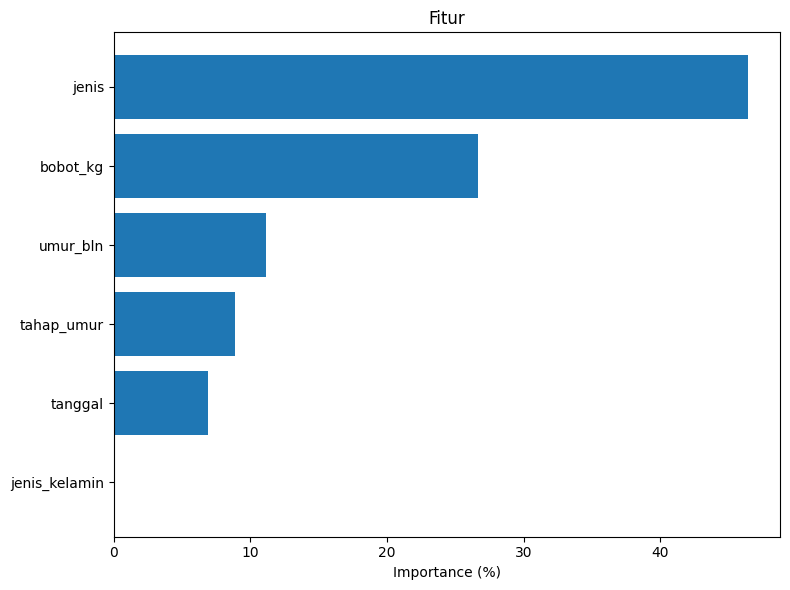

In [ ]:
perm = permutation_importance(
    gbr_tuned_pipe, X, y,
    n_repeats=8,
    random_state=42,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False)
)

raw_features = list(X.columns)
imp_df = pd.DataFrame({
    "feature": raw_features,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

imp_df["importance_pct"] = (
    imp_df["importance_mean"] / imp_df["importance_mean"].sum() * 100
)


topk = min(15, len(imp_df))
plt.figure(figsize=(8, 6))
plt.barh(
    imp_df["feature"].head(topk)[::-1],
    imp_df["importance_pct"].head(topk)[::-1]
)
plt.xlabel("Importance (%)")
plt.title("Fitur")
plt.tight_layout()
plt.show()

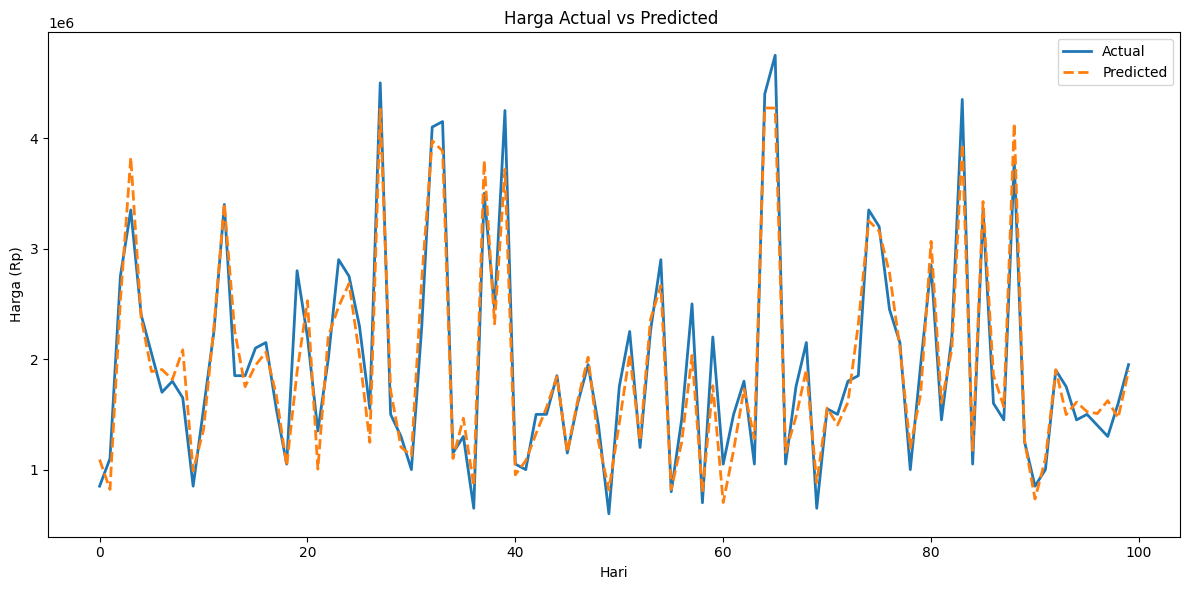

In [ ]:
cv_oof = KFold(n_splits=5, shuffle=True, random_state=42)
x_axis_full = np.arange(len(X))

X_cv = X.reset_index(drop=True)
y_cv = y.reset_index(drop=True)
y_oof = np.full(shape=len(X_cv), fill_value=np.nan, dtype=float)

for tr_idx, te_idx in cv_oof.split(X_cv, y_cv):
    gbr_tuned_pipe.fit(X_cv.iloc[tr_idx], y_cv.iloc[tr_idx])
    y_oof[te_idx] = gbr_tuned_pipe.predict(X_cv.iloc[te_idx])

mask = ~np.isnan(y_oof)
df_oof = pd.DataFrame({
    "x": x_axis_full[mask].values if hasattr(x_axis_full, "values") else x_axis_full[mask],
    "Actual": y_cv[mask].values,
    "Predicted_OOF": y_oof[mask]
})

plt.figure(figsize=(12, 6))
plt.plot(df_oof["x"], df_oof["Actual"], label="Actual", linewidth=2)
plt.plot(df_oof["x"], df_oof["Predicted_OOF"], label="Predicted", linewidth=2, linestyle="--")
plt.title("Harga Actual vs Predicted ")
plt.xlabel("Hari" if ("tanggal" in df.columns) else "Index Data")
plt.ylabel("Harga (Rp)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pred_sample = gbr_tuned_pipe.predict(X.head(25))
preview_cols = [c for c in ["jenis", "tahap_umur", "umur_bln", "bobot_kg", "jenis_kelamin", "tanggal", "year", "month", "week", "dow"] if c in X.columns]
preview = pd.concat([X[preview_cols].head(25).reset_index(drop=True),
                     df[TARGET_COL].head(25).reset_index(drop=True)], axis=1)
preview["prediksi_harga_rp"] = np.round(pred_sample, 0)

print("Contoh Hasil Prediksi Dalam Bentuk Tabel")
print(preview.to_string(index=False))

Contoh Hasil Prediksi Dalam Bentuk Tabel
               jenis tahap_umur  umur_bln  bobot_kg jenis_kelamin    tanggal  harga_rp  prediksi_harga_rp
               Gibas       Muda        10      26.2        Betina 2023-01-10    850000           934463.0
               Gibas       Muda         9      24.8        Jantan 2023-01-19   1100000           820547.0
Peranakan Etawa (PE)       Muda        12      34.6        Jantan 2023-01-28   2750000          2528182.0
Peranakan Etawa (PE)     Dewasa        17      42.9        Betina 2023-01-29   3350000          3402070.0
          Jawa Randu     Dewasa        18      36.8        Jantan 2023-02-01   2400000          2369033.0
          Jawa Randu       Muda        12      27.5        Betina 2023-02-27   2050000          2017229.0
Peranakan Etawa (PE)       Muda         7      22.4        Jantan 2023-04-22   1700000          1710034.0
               Gibas     Dewasa        20      35.9        Jantan 2023-04-25   1800000          1816309.0
     